In [1]:
import pandas as pd 
import numpy as np 
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
def trim_categories(df, cols_list):
    for col in cols_list:
        df[col].cat.rename_categories(df[col].cat.categories.str.strip(), inplace=True)

# Import data, setting dtype to save memory

In [3]:
levels_keep_cols = ['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']
levels_col_types = {'TankId': 'category',
             'ExactFuelEventId': 'uint64',
             'TankLevelPercent': 'float32',
             'TankLevelGallons': 'float32'}
#Rows with TankId == '2' are dropped on read-in, after being manually identified
levels_fueltank_df = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv', 
                                 skiprows=[48671, 1824800, 4579415, 5656381],
                                 usecols = levels_keep_cols, 
                                 dtype=levels_col_types ).drop(
    ['TankId'], axis=1)

#levels_fueltank_df = levels_fueltank_df.set_index('ExactFuelEventId').drop(['TankId'], axis=1)

#### Fuel Optimization data; only need tank capacity

In [4]:
optimization_fuel_df = pd.read_csv('data/BGEIDSC.EF2EFFP.csv',
                                   dtype={'TANKCAP': 'uint16', 'TRUCK' : 'uint32'},
                                  usecols = ['TRUCK', 'TANKCAP'])
optimization_fuel_df.columns = [s.lower() for s in optimization_fuel_df.columns]

In [5]:
#trim_categories(optimization_fuel_df, ['truck'])
#optimization_fuel_df.set_index('truck', inplace=True)

In [6]:
units_df = pd.read_csv('data/IBGEFILE.UNITS.csv', 
                       dtype = {'UNMAKE': 'category'})
#Can drop non-int units
units_df.columns = ['unit_number', 'model_year', 'make'] 

# Trim white space from category strings 

# Remove invalid entries
units_df.unit_number = pd.to_numeric(units_df.unit_number, errors = 'coerce')
units_df = units_df[units_df.unit_number != 1].dropna()
#units_df = units_df[units_df.unit_number.isin(['ZEBE', 'CCTRK', 'BGXL', '1']) == False]
#set index

trim_categories(units_df, ['make'])
# Fix typos
units_df.make[units_df.make.isin(['KENOWRTH', 'KEWORTH'])] = 'KENWORTH'


In [7]:
units_df.make.cat.categories

Index(['', 'FREIGHTLINER', 'KENOWRTH', 'KENWORTH', 'KEWORTH', 'MACK',
       'PETERBILT', 'SYSTEM TEST', 'VOLVO'],
      dtype='object')

In [8]:
units_df.make.value_counts()

KENWORTH        526
VOLVO           139
FREIGHTLINER     15
PETERBILT        14
MACK             10
SYSTEM TEST       0
KEWORTH           0
KENOWRTH          0
                  0
Name: make, dtype: int64

In [9]:
transaction_df_cols = ['tr_id', 'tr_date', 'tr_time', 'tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 
                         'tr_item_cd1', 'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2',
                          'tr_item_cd3', 'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4',
                          'tr_item_cd5', 'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6']
tr_dtypes= {'tr_id' : 'uint32',  
            'tr_date' : 'uint32', 
            'tr_time' : 'uint32', 
            'tr_station_name' : 'object', 
            'tr_station_cty' : 'object', 
            'tr_station_st' : 'object', 
            'tr_drvr_code' : 'category', 
            'tr_unit_id' : 'category', 
            'tr_item_cd1' : 'category', 
            'tr_item_qty1' : 'float32', 
            'tr_item_cd2' : 'category', 
            'tr_item_qty2' : 'float32', 
            'tr_item_cd3' : 'category', 
            'tr_item_qty3' : 'float32', 
            'tr_item_cd4' : 'category', 
            'tr_item_qty4' : 'float32', 
            'tr_item_cd5' : 'category', 
            'tr_item_qty5' : 'float32', 
            'tr_item_cd6' : 'category', 
            'tr_item_qty6' : 'float32'}
act_fuel_transactions = ['ULSD', 'FUEL', 'CDSL', 'DSL1', 'BDSL']
transaction_df = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv', names = transaction_df_cols, dtype = tr_dtypes, header=0 )

# Trim white space from category strings 
trim_categories(transaction_df, ['tr_drvr_code','tr_unit_id','tr_item_cd1', 'tr_item_cd2', 'tr_item_cd3', 'tr_item_cd4', 'tr_item_cd5', 'tr_item_cd6' ])

#### Create datetime column in transactions_df

In [10]:
#confirm no junk data in this col (returns false if no NaNs)
None in transaction_df.tr_time

# 20170112 3

#Combine tr_date and tr_time into a single date time column
    #1. zero pad tr_time on left for interpretation as military time
        #cast tr_time as string
transaction_df.tr_time = transaction_df.tr_time.astype(str)

# 20170112 '3' Time column is now a string
#ensure none of my strings are over 4 digits in length
for s in transaction_df.tr_time:
    assert len(s) < 5

#check for blanks
'' in transaction_df.tr_time

#add zeros to the left until each cell is len 4
zero_padded_time = []
for s in transaction_df.tr_time:
    while len(s) < 4:
        s = '0' + s
    zero_padded_time.append(s)
# 20170112 '0003' zero padded minutes
#spot check
for s in zero_padded_time:
    assert len(s) == 4

transaction_df.tr_time = zero_padded_time

#append tr_date (as string) and tr_time together, and then convert them to dateime
#transaction_df.tr_datetime 
tst = [datetime.strptime(str(d) + 
                         t, '%Y%m%d%H%M') 
       for d, t in zip(transaction_df.tr_date,
                       transaction_df.tr_time)]
#love list comprehensions

transaction_df['tr_datetime'] = tst#assign

#drop superfluous columns
transaction_df.drop(['tr_date','tr_time'], axis = 'columns', inplace=True)
transaction_df.head()

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
0,42574765,520277,FLYING J VANDALIA 97,VANDALIA,OH,ULAL,1564,SCLE,1.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 00:20:00
1,42575331,516202,PILOT NEW BRAUNFELS 330,NEW BRAUNFELS,TX,MANRI,1584,ULSD,137.399994,DEFD,7.71,CADV,1.0,,0.0,,0.0,,0.0,2017-01-01 00:48:00
2,42578678,516277,PILOT 421,DALTON,GA,RUSR,1713,ULSD,137.929993,DEFD,4.12,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:34:00
3,42578722,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,FOSJA,1711,ULSD,45.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:37:00
4,42579695,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HICWIL,1837,ULSD,107.360001,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 03:02:00


In [11]:
transaction_df.tr_item_cd2.value_counts()

        96333
DEFD    42468
CADV     8196
ADD       348
OIL       264
SCLE      236
UREA       15
WWFL        1
Name: tr_item_cd2, dtype: int64

In [12]:
# These rows are dropped
transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '']) == True]

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
1174,42977478,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 07:40:00
1383,43037746,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,130.570007,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 14:57:00
6812,44866479,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,60.790001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 06:08:00
6955,44908231,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,30.440001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 14:33:00
13493,47176337,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,96.269997,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-09 09:11:00
15203,47747773,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,62.840000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 10:46:00
16503,48174487,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,82.480003,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 11:53:00
16583,48198811,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 15:01:00
17310,48478526,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,1974,,ULSD,10.060000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-20 12:12:00
18077,48727766,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,88.010002,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-22 09:42:00


In [13]:
# Drops Office and blank Unit IDs
#transaction_df = transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '      ']) == False]

In [14]:
events_keep_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 
                    'DriverID', 'Latitude', 'Longitude', 'LocationTimeStamp', 
                    'Speed', 'Odometer', 'IgnitionStatus', 'EFReportReason']
events_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'EquipmentID': 'uint32',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'Odometer': 'float64',
             'Speed': 'uint16'}

events_levels_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True).merge(
    levels_fueltank_df, copy=False, how='inner', left_on='Id', right_on='ExactFuelEventId').merge(
    optimization_fuel_df, copy=False, how='left', left_on='EquipmentID', right_on = 'truck')
trim_categories(events_levels_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])

In [15]:
'''events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             index_col = 'EventTimeStamp',
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True)
trim_categories(events_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])
'''

"events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', \n                             usecols=events_keep_cols, \n                            dtype=events_col_types, \n                             index_col = 'EventTimeStamp',\n                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], \n                            infer_datetime_format=True)\ntrim_categories(events_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])\n"

In [16]:
# Save 220 MB memory and 
levels_fueltank_df.index = levels_fueltank_df.index.astype('uint64')
gc.collect()

2835

In [18]:
performance_df = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv',
                            parse_dates=['EventTimeStamp','LocationTimeStamp', 'DataStartTimeStamp','DataEndTimeStamp' ], 
                            infer_datetime_format=True)
# Remove invalid Truck IDs
performance_df = performance_df[performance_df.EquipmentID < 9999]

In [19]:
performance_df[performance_df.RegisteredDriver == 0].DriverID.value_counts()

000000000    65
STEMI        58
MARC         55
LOVH         55
BUFB         54
STEGA        54
PEAA         54
NEWR         54
FISG         54
COLJAM       53
TUSR         53
JONCH        53
GREG         52
BROBO        52
WALCA        52
THODAV       52
SHAMAR       52
HOWLE        52
WESD         52
ANTR         52
WILT01       52
MARMIS       52
FIEMI        52
SCHD         52
VANCH        52
BAYJ         52
HARTI        51
MEAJ         51
ARCM         51
POPP         51
             ..
WEIJ          1
000001559     1
RATW          1
JONDO         1
ROBAA         1
JACJOH        1
BOSB          1
FOSR          1
CALR          1
HAZSC         1
MOSAD         1
BAUJ          1
000001045     1
ROWP          1
RYAC          1
DAYR          1
JONJOH        1
BRIK          1
NEWC          1
FOUJ          1
DUNM          1
BONK          1
MCDS          1
SHOJO         1
GOOA          1
CHIW          1
LACJO         1
GOOJO         1
000002033     1
LOPJO         1
Name: DriverID, Length: 

In [20]:
perf_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 'DriverID', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed',
        'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits', 'LocationTimeStamp', 'Latitude', 'Longitude', 
            'FaultFlag', 'RegisteredDriver',]
performance_df.columns

Index(['Id', 'ESS_Id', 'EventTimeStamp', 'EquipmentID', 'MCTNumber',
       'EquipmentType', 'DriverID', 'Driver2ID', 'Latitude', 'Longitude',
       'LocationTimeStamp', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'ExcessSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed',
       'FaultFlag', 'RegisteredDriver', 'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits', 'SpeedMatrix'],
      dtype='object')

In [21]:
df_names_list = ['events_levels_df', 'levels_fueltank_df', 'optimization_fuel_df', 'units_df', 'transaction_df', 'performance_df']
df_list = [events_levels_df, levels_fueltank_df, optimization_fuel_df, units_df, transaction_df, performance_df]
df_dict = dict(zip(df_names_list, df_list))

for k, v in df_dict.items():
    print(k + ' shape: ' + str(v.shape))

events_levels_df shape: (7908406, 16)
levels_fueltank_df shape: (7908824, 3)
optimization_fuel_df shape: (836, 2)
units_df shape: (704, 3)
transaction_df shape: (147861, 20)
performance_df shape: (32253, 32)


In [22]:
events_levels_df.head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,2017-01-01 00:00:30,0,39895.5,2,1,50.700001,101.400002,12649083,1992,200
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,2017-01-01 00:01:27,0,360378.8,1,2,78.000000,156.000000,12649084,1712,200
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,2017-01-01 00:04:17,67,377577.4,1,2,31.700001,63.400002,12649092,1713,200
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,2017-01-01 00:04:10,0,513931.8,1,2,43.200001,108.000000,12649102,1585,250
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250


#### Events grouped by Driver and Truck

In [23]:
dt_grouped = events_levels_df.groupby(['DriverID', 'EquipmentID'])

#### Sizes of groups as a dataframe

In [24]:
dt_sizes = dt_grouped.size().to_frame('events').sort_values('events', ascending=False)

In [25]:
dt_sizes.shape

(2151, 1)

In [26]:
dt_sizes[dt_sizes.events < 20].shape[0]

340

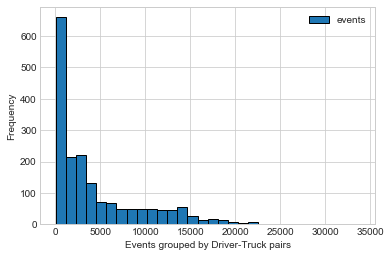

In [27]:
sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
dt_sizes[dt_sizes.events > 20].plot(kind='hist', bins=30)
plt.xlabel('Events grouped by Driver-Truck pairs')
plt.show()

In [28]:
dt_sizes.head(50).sort_index()

,,events
DriverID,EquipmentID,
ADAR,1950,18387
ANTR,1721,20956
ARCM,307,18415
BALD,1991,19249
BINA,1961,17271
BROD03,1941,22014
BUFB,1799,18922
BULR,1639,17809
BYRCHR,1734,18425


### Sample data for specific drivers

In [29]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
events_col_list = ['EventTimeStamp', 'Odometer', 'TankLevelPercent', 'IgnitionStatus', 'EFReportReason',
                   'Speed',  'TankLevelGallons', 'Latitude', 'Longitude', 'LocationTimeStamp',
                  'tankcap', 'EquipmentID', 'DriverID']
sample_bool_series = np.logical_and(events_levels_df.DriverID.isin(sample_drivers), 
                                   events_levels_df.EquipmentID.isin(sample_trucks))
drivers_events = events_levels_df[sample_bool_series].loc[:, events_col_list].set_index('EventTimeStamp')

In [30]:
drivers_events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20294 entries, 2017-01-07 17:28:16.870000 to 2018-03-23 08:19:22.510000
Data columns (total 12 columns):
Odometer             20294 non-null float64
TankLevelPercent     20294 non-null float32
IgnitionStatus       20294 non-null category
EFReportReason       20294 non-null category
Speed                20294 non-null uint16
TankLevelGallons     20294 non-null float32
Latitude             20294 non-null float64
Longitude            20294 non-null float64
LocationTimeStamp    20294 non-null datetime64[ns]
tankcap              20294 non-null uint16
EquipmentID          20294 non-null uint32
DriverID             20294 non-null category
dtypes: category(3), datetime64[ns](1), float32(2), float64(3), uint16(2), uint32(1)
memory usage: 1.2 MB


In [31]:
'''event_col_list = ['Odometer',  'IgnitionStatus', 'EFReportReason',
                   'Speed',  'Latitude', 'Longitude', 'LocationTimeStamp',
                  'EquipmentID', 'DriverID']
driver_event_filter = np.logical_and(events_df.DriverID.isin(sample_drivers), 
                                   events_df.EquipmentID.isin(sample_trucks))
drivers_events_full = events_df[driver_event_filter].loc[:, event_col_list]'''

"event_col_list = ['Odometer',  'IgnitionStatus', 'EFReportReason',\n                   'Speed',  'Latitude', 'Longitude', 'LocationTimeStamp',\n                  'EquipmentID', 'DriverID']\ndriver_event_filter = np.logical_and(events_df.DriverID.isin(sample_drivers), \n                                   events_df.EquipmentID.isin(sample_trucks))\ndrivers_events_full = events_df[driver_event_filter].loc[:, event_col_list]"

In [32]:
drivers_events.loc['2017-01-12 05:56': '2017-01-12 12:15']

,Odometer,TankLevelPercent,IgnitionStatus,EFReportReason,Speed,TankLevelGallons,Latitude,Longitude,LocationTimeStamp,tankcap,EquipmentID,DriverID
EventTimeStamp,,,,,,,,,,,,
2017-01-12 05:56:31.780,1597.5,27.900000,2,0,0,55.799999,40.23532,-77.12209,2017-01-12 05:55:57,200,2014,EDWTI
2017-01-12 06:12:31.797,1597.6,70.199997,2,1,0,140.399994,40.23534,-77.12239,2017-01-12 06:12:31,200,2014,EDWTI
2017-01-12 06:16:01.797,1597.7,100.000000,1,0,10,200.000000,40.23444,-77.12103,2017-01-12 06:16:01,200,2014,EDWTI
2017-01-12 06:31:01.843,1608.3,100.000000,1,2,64,200.000000,40.19640,-77.00968,2017-01-12 06:31:01,200,2014,EDWTI
2017-01-12 07:31:02.280,1669.4,100.000000,1,2,61,200.000000,40.17710,-75.92836,2017-01-12 07:31:01,200,2014,EDWTI
2017-01-12 08:30:59.413,1730.5,95.800003,1,2,54,191.600006,40.12595,-74.87093,2017-01-12 08:31:02,200,2014,EDWTI
2017-01-12 09:04:39.447,1762.3,93.199997,1,2,7,186.399994,40.34993,-74.48066,2017-01-12 09:04:42,200,2014,EDWTI
2017-01-12 09:14:49.460,1764.2,96.199997,2,1,0,192.399994,40.35500,-74.45721,2017-01-12 09:14:52,200,2014,EDWTI
2017-01-12 09:19:49.507,1764.6,99.000000,1,0,7,198.000000,40.35387,-74.45072,2017-01-12 09:19:52,200,2014,EDWTI


In [33]:
'''events_df.info(memory_usage='deep')'''

"events_df.info(memory_usage='deep')"

In [34]:
'''#drivers_events_full.info()
len(drivers_events_full.loc['2017-01-12'])
#drivers_events_full.head()'''

"#drivers_events_full.info()\nlen(drivers_events_full.loc['2017-01-12'])\n#drivers_events_full.head()"

In [35]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
trans_col_list = ['tr_datetime','tr_item_cd1', 'tr_item_qty1', 'tr_station_id', 
                  'tr_station_name','tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id']
    

sample_tran_bool_series = np.logical_and(transaction_df.tr_drvr_code.isin(sample_drivers), 
                                   transaction_df.tr_unit_id.isin(sample_trucks))
drivers_trans = transaction_df[sample_tran_bool_series].loc[:, trans_col_list].sort_values(['tr_datetime'])

In [36]:
transaction_df.columns

Index(['tr_id', 'tr_station_id', 'tr_station_name', 'tr_station_cty',
       'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 'tr_item_cd1',
       'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2', 'tr_item_cd3',
       'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4', 'tr_item_cd5',
       'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6', 'tr_datetime'],
      dtype='object')

In [37]:
drivers_trans[:4]

,tr_datetime,tr_item_cd1,tr_item_qty1,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id
3625,2017-01-12 06:10:00,ULSD,138.0,231060,FJ-CARLISLE 708,CARLISLE,PA,EDWTI,2014
4034,2017-01-13 06:00:00,SCLE,1.0,516089,PILOT 179,HAGERSTOWN,MD,EDWTI,2014
4154,2017-01-13 10:55:00,ULSD,102.0,231846,FJ-MAX MEADOWS 750,FORT CHISWELL,VA,EDWTI,2014
4447,2017-01-14 09:19:00,SCLE,1.0,516127,PILOT MIDDLESBORO 240,MIDDLESBORO,KY,EDWTI,2014


## Cleaning up odometer data in evets_levels_df

In [38]:
events_levels_df.head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,2017-01-01 00:00:30,0,39895.5,2,1,50.700001,101.400002,12649083,1992,200
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,2017-01-01 00:01:27,0,360378.8,1,2,78.000000,156.000000,12649084,1712,200
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,2017-01-01 00:04:17,67,377577.4,1,2,31.700001,63.400002,12649092,1713,200
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,2017-01-01 00:04:10,0,513931.8,1,2,43.200001,108.000000,12649102,1585,250
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250


In [39]:
#Are there bad odometer readings?
events_levels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908406 entries, 0 to 7908405
Data columns (total 16 columns):
Id                   uint64
EventTimeStamp       datetime64[ns]
EquipmentID          uint32
DriverID             category
Latitude             float64
Longitude            float64
LocationTimeStamp    datetime64[ns]
Speed                uint16
Odometer             float64
IgnitionStatus       category
EFReportReason       category
TankLevelPercent     float32
TankLevelGallons     float32
ExactFuelEventId     uint64
truck                uint32
tankcap              uint16
dtypes: category(3), datetime64[ns](2), float32(2), float64(3), uint16(2), uint32(2), uint64(2)
memory usage: 663.7 MB


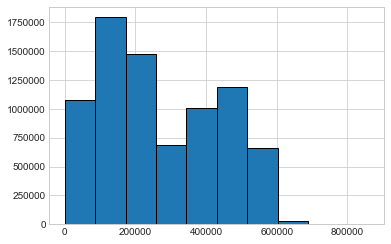

In [40]:
#well at least they're all floats. I guess I could try a histogram
_ = plt.hist(events_levels_df.Odometer)
plt.show()

In [41]:
#Ok so, some readings are quite high. 
#And while it is rare that a truck would have 600,000 + miles on it. 
#at least there is nothing absurd like a million miles.

#I guess I could group by truck, and then check a timeseries of odometer
#for each truck. the mileage should increase gradually for all trucks.

#So how many trucks are there?
#len(set(events_levels_df.truck)) #there are 629 trucks.

In [42]:
#len(set(events_levels_df.EquipmentID)) #confirming its a 1 to 1 match with truck

In [43]:
#set(events_levels_df.EquipmentID) == set(events_levels_df.truck)
#confirming the sets are the same 
    ####This took 2 minutes but it was True

In [44]:
#so drop the unecessary column of EquipmentID
events_levels_df.drop('EquipmentID', axis = 1, inplace = True)

In [45]:
set(events_levels_df.truck) #quick visual inspection

{301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 1508,
 1513,
 1516,
 1519,
 1520,
 1521,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1534,
 1535,
 1537,
 1539,
 1543,
 1547,
 1548,
 1549,
 1550,
 1551,
 1552,
 1554,
 1555,
 1556,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 1572,
 1573,
 1574,
 1575,
 1576,
 1577,
 1578,
 1579,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1601,
 1602,
 1603,
 1604,
 1607,
 1608,
 1609,
 1610,
 1611,
 1612,
 1613,
 1614,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1622,
 1623,
 1624,
 1625,
 1626,
 1627,
 1628,
 1629,
 1630,
 1631,
 1632,
 1633,
 1634,
 1635,
 1636,
 1638,
 1639,
 1640,
 1641,
 1642,
 1643,
 1644,
 1645,
 1647,
 1648,
 1649,
 1650,
 1651,
 1652,
 1653,
 1654,
 1655,
 1656,
 1657,
 1658,
 1659,
 1660,
 1661,
 1662,
 1663,
 1664,
 1665,
 1666,
 1

In [46]:
#so.... group by truck, sort by time and plot odometer time series?
    #I don't need 629 plots...
    #Can I handle, 629 lines on a single plot? sounds computationally expensive

#Numerical approach: group by truck, sort chronologically
    #for each row in df:
        #if (truck i == truck i+1) and (Odometer i+1 - Odometer i > 500):
            #print('found weird jump between odometer i and odometer i+1 for truck t')

events_levels_df[0:100].sort_values(['truck', 'EventTimeStamp'])

,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
4,12649103,2017-01-01 00:10:13.187,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250
44,12649143,2017-01-01 00:12:23.187,ULAL,39.90267,-84.19318,2017-01-01 00:12:21,9,498691.1,1,1,50.599998,126.500000,12649143,1564,250
45,12649144,2017-01-01 00:14:13.187,ULAL,39.90259,-84.19231,2017-01-01 00:14:11,0,498691.2,2,1,50.400002,126.000000,12649144,1564,250
46,12649145,2017-01-01 00:14:34.267,ULAL,39.90262,-84.19234,2017-01-01 00:14:32,0,498691.2,2,0,50.400002,126.000000,12649145,1564,250
47,12649146,2017-01-01 00:32:13.267,ULAL,39.90261,-84.19228,2017-01-01 00:32:11,0,498691.2,2,1,48.799999,122.000000,12649146,1564,250
48,12649147,2017-01-01 00:36:23.297,ULAL,39.90302,-84.19245,2017-01-01 00:36:21,9,498691.2,1,0,48.000000,120.000000,12649147,1564,250
49,12649148,2017-01-01 00:51:23.390,ULAL,39.75214,-84.18651,2017-01-01 00:51:21,57,498703.8,1,2,48.000000,120.000000,12649148,1564,250
10,12649109,2017-01-01 00:14:33.237,MANRI,29.53947,-98.37978,2017-01-01 00:14:34,56,500730.0,1,2,30.900000,77.250000,12649109,1584,250
20,12649119,2017-01-01 00:30:13.330,MANRI,29.67382,-98.15442,2017-01-01 00:30:14,10,500746.3,1,2,28.400000,71.000000,12649119,1584,250
29,12649128,2017-01-01 00:36:13.393,MANRI,29.67678,-98.15673,2017-01-01 00:36:14,0,500747.1,2,1,29.000000,72.500000,12649128,1584,250


In [47]:
events_levels_df[0:50].pivot(index = 'EventTimeStamp', 
                              columns = 'truck',
                             values = 'Odometer')

truck,1564,1584,1585,1612,1672,1693,1707,1711,1712,1713,1730,1787,1913,1922,1992
EventTimeStamp,,,,,,,,,,,,,,,
2017-01-01 00:00:32.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39895.5
2017-01-01 00:01:24.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360378.8,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:04:10.260,NaN,NaN,513931.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:04:15.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377577.4,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:10:13.187,498691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:11:08.123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:11:48.803,NaN,NaN,NaN,NaN,NaN,340043.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:12:23.187,498691.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:12:26.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224306.6,NaN,NaN,NaN


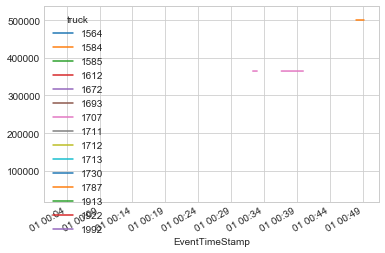

In [48]:
events_levels_df[0:50].pivot(index = 'EventTimeStamp', columns = 'truck', 
                      values = 'Odometer').plot()
plt.show()

### This approach fails when it detects duplicated "index" values. i.e. duplicated dates. 

In [49]:
##ploting one single trucks odometer time series

events_levels_df[events_levels_df.truck == 1564].plot(x = 'EventTimeStamp', y = 'Odometer')

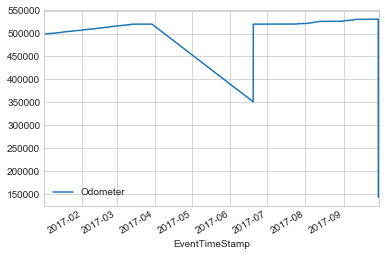

In [50]:
plt.show()

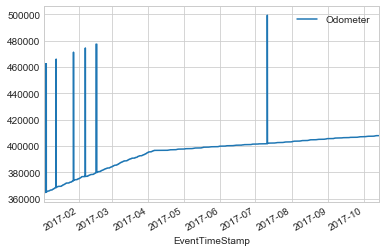

In [51]:
events_levels_df[events_levels_df.truck == 1563].plot(x = 'EventTimeStamp', y = 'Odometer')
plt.show()

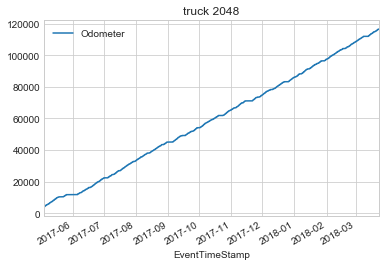

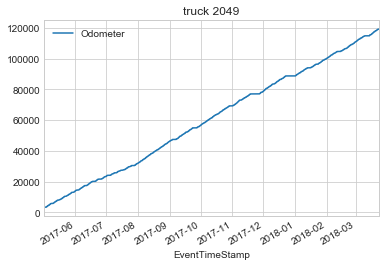

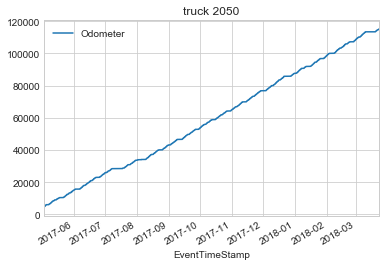

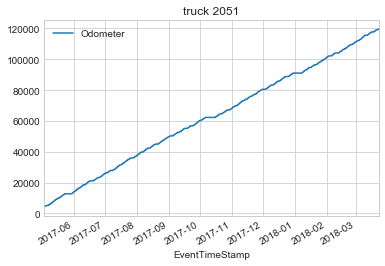

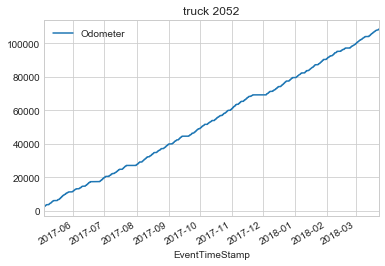

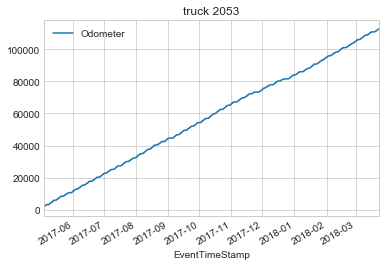

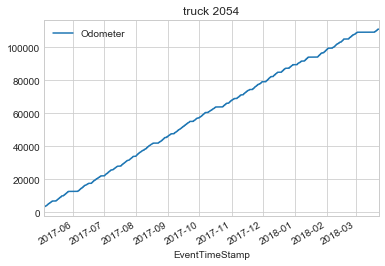

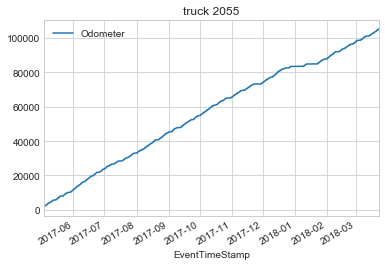

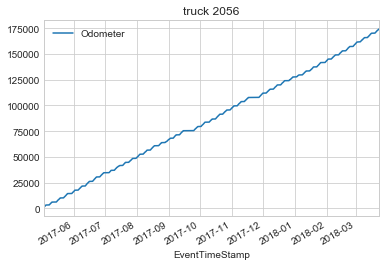

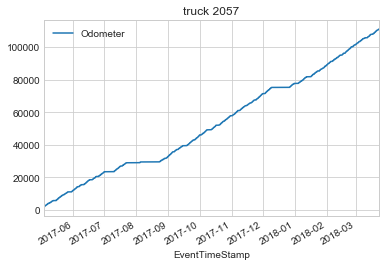

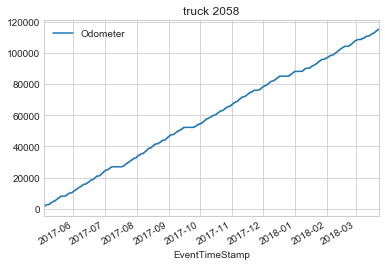

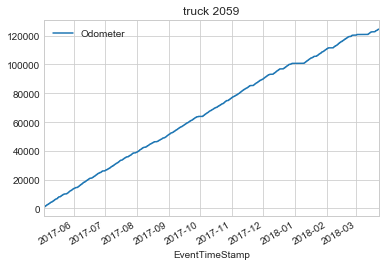

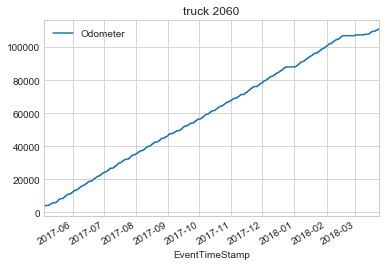

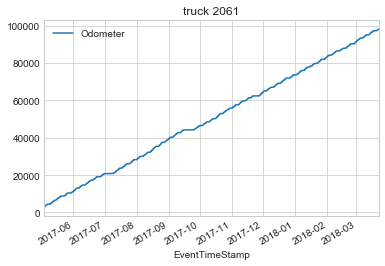

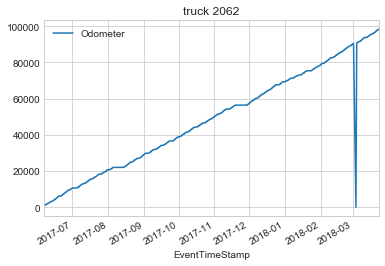

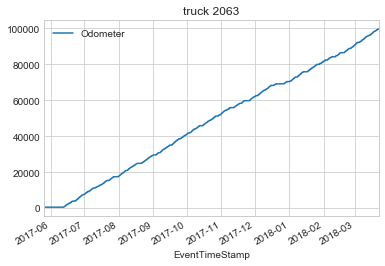

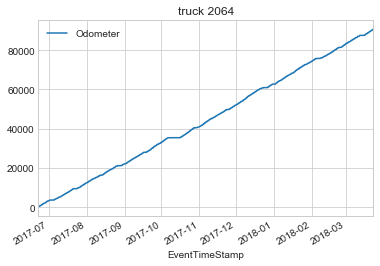

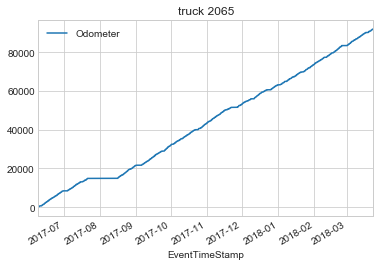

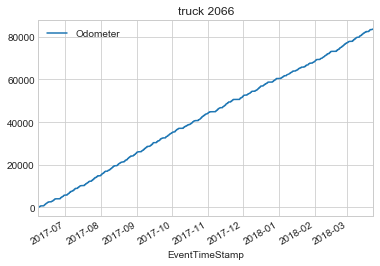

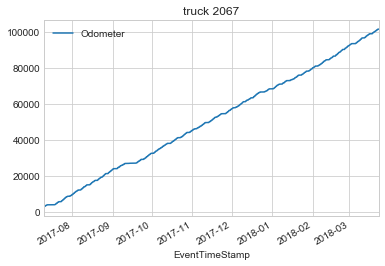

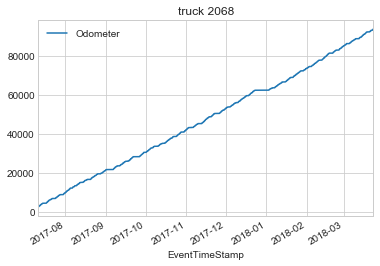

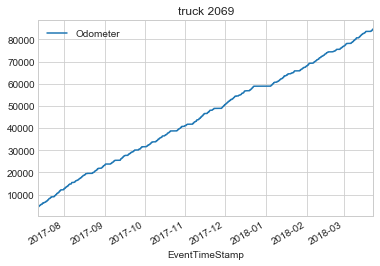

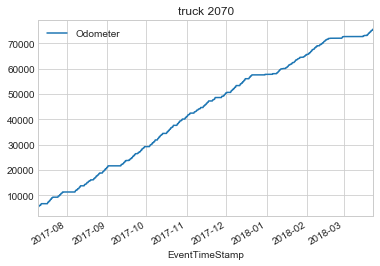

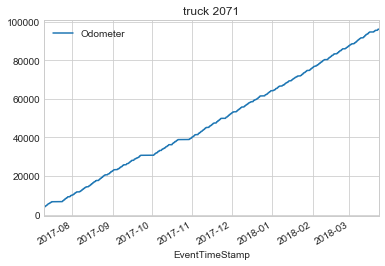

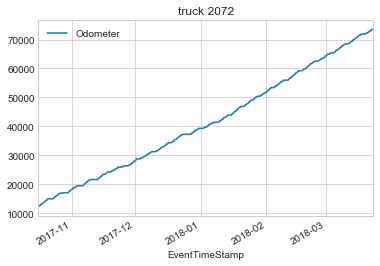

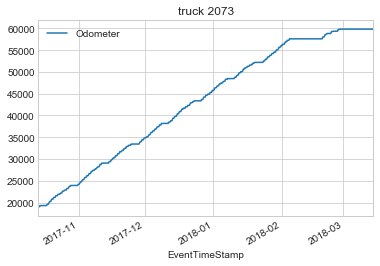

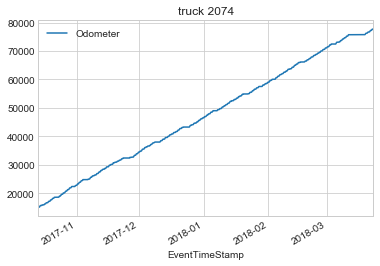

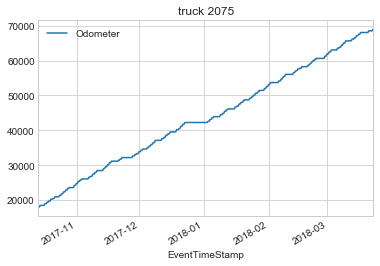

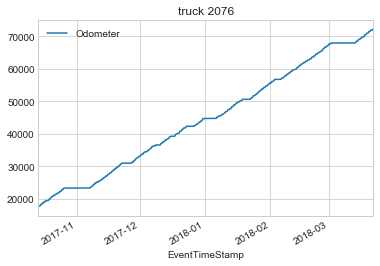

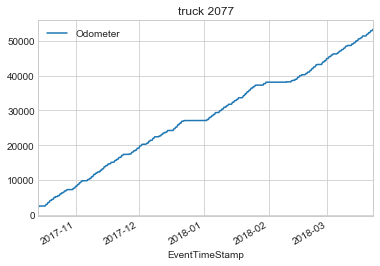

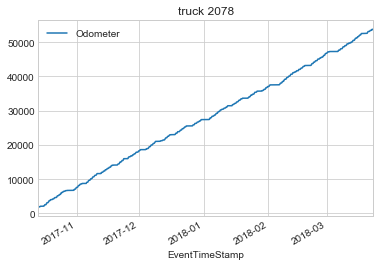

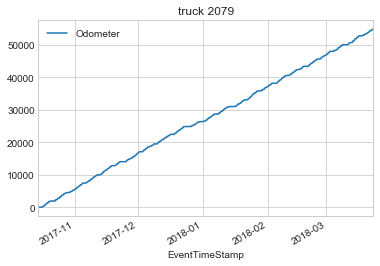

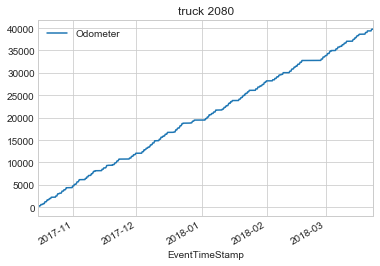

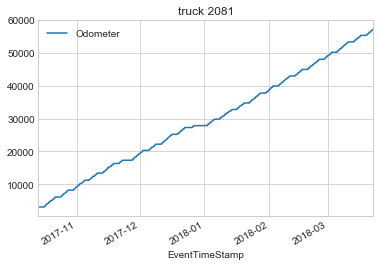

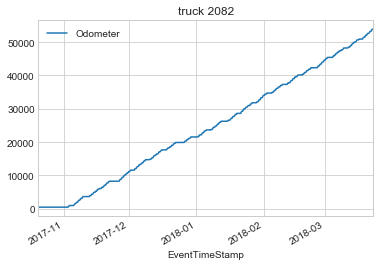

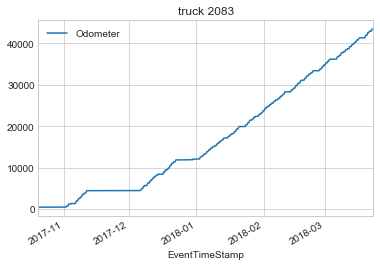

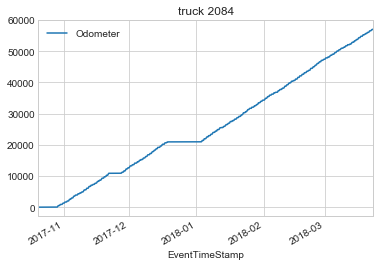

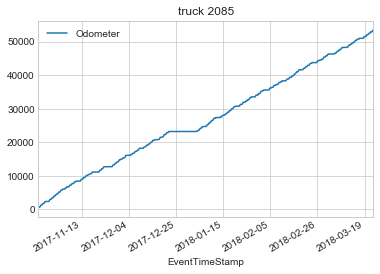

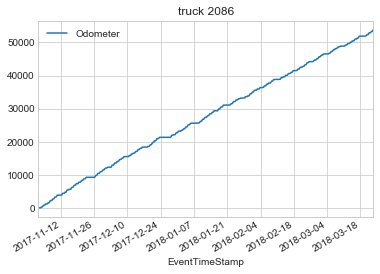

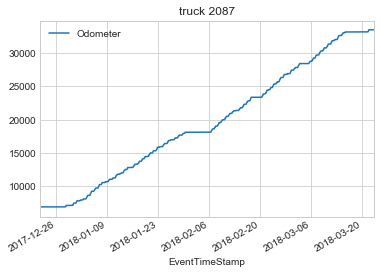

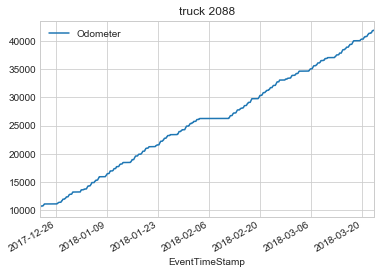

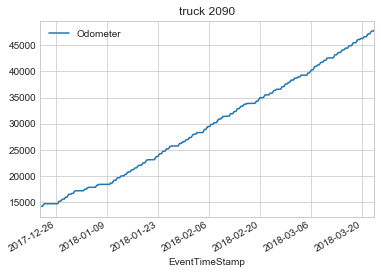

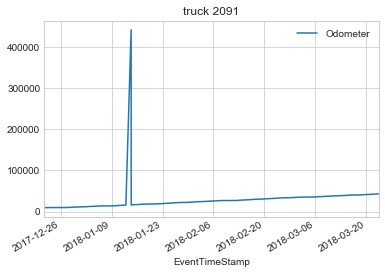

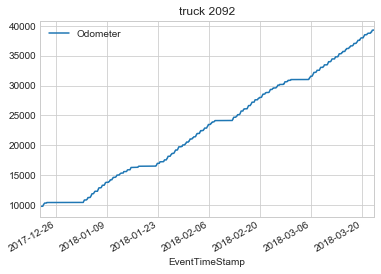

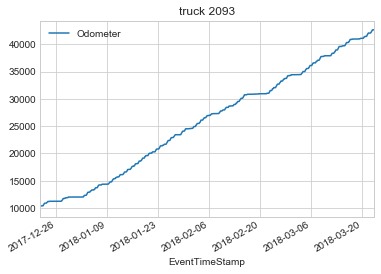

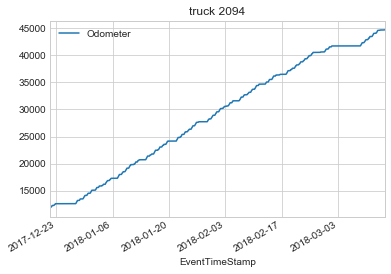

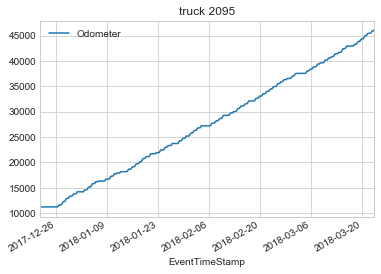

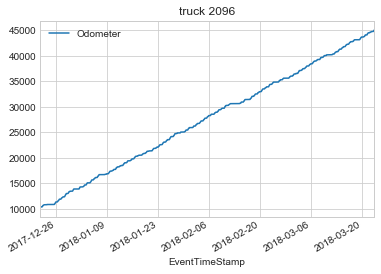

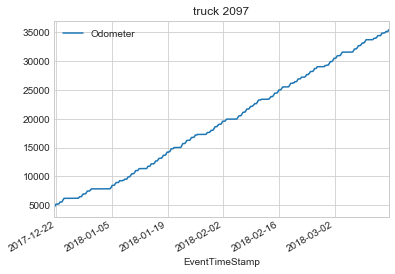

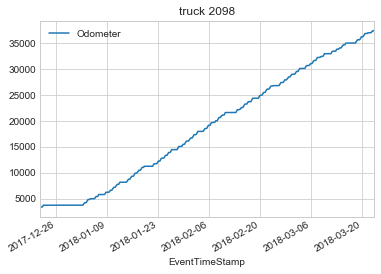

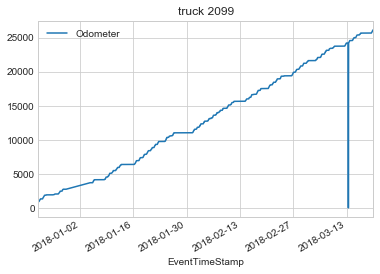

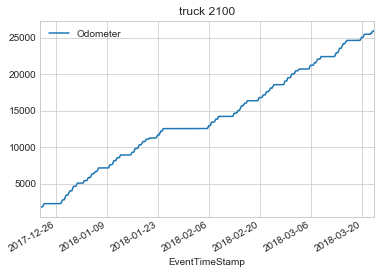

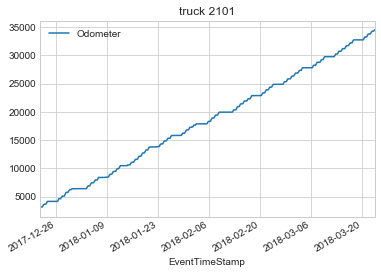

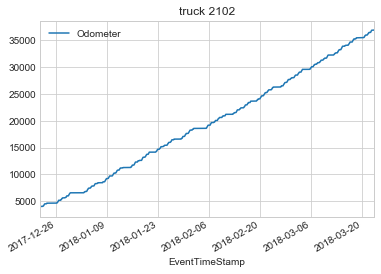

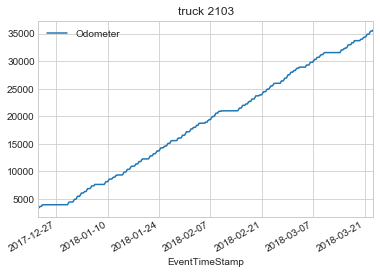

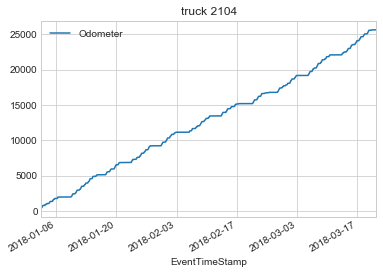

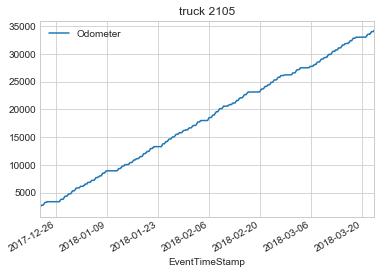

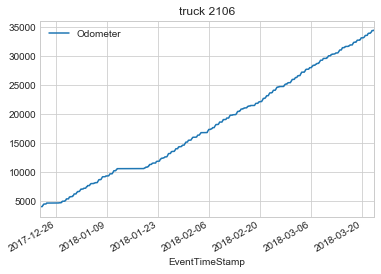

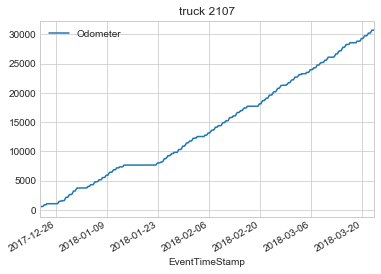

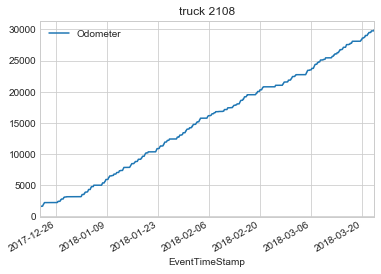

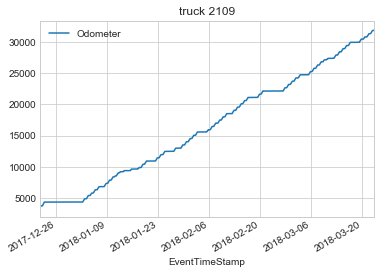

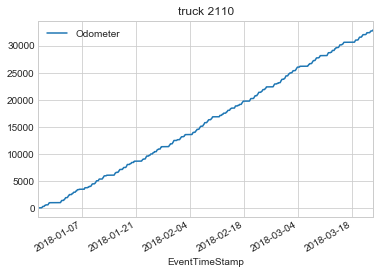

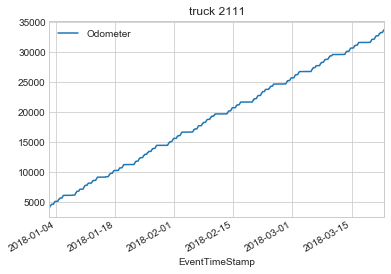

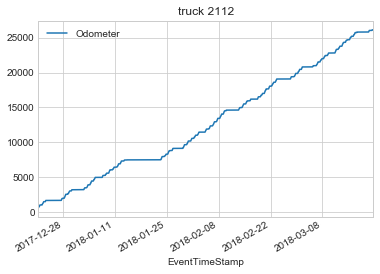

KeyboardInterrupt: 

In [52]:
#this cell will generate 629 odometer plot series. One for every truck.
    #it takes about 5 minutes

#for truck in list(set(events_levels_df.truck)):
#    _ = events_levels_df[events_levels_df.truck == truck].plot(x = 'EventTimeStamp', y = 'Odometer', 
#                                                               title = 'truck ' + str(truck))
#    plt.show()

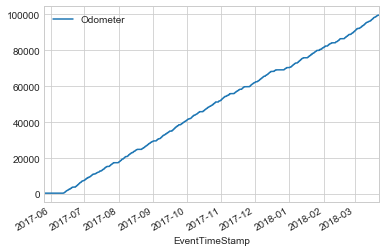

In [53]:
events_levels_df[events_levels_df.truck == 2063].plot(x = 'EventTimeStamp', y = 'Odometer', )
plt.show()

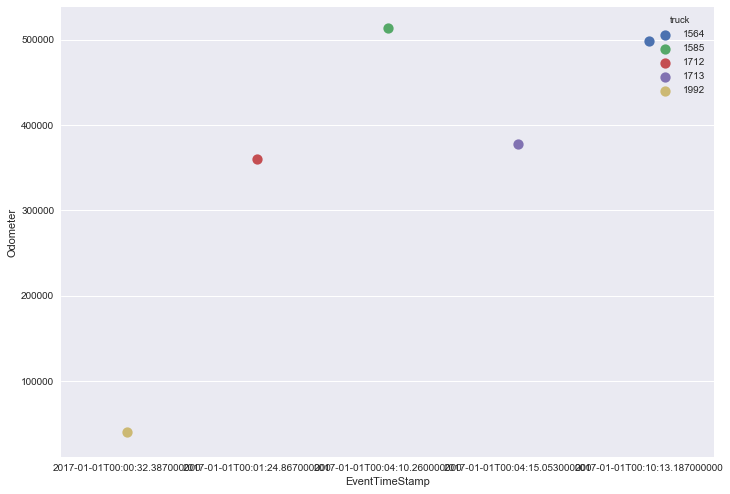

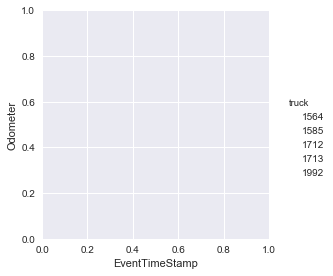

In [77]:
#try with sns
sns.set(style='darkgrid')

f, ax = plt.subplots()

f.set_size_inches(11.7, 8.27)

sns.factorplot(x = 'EventTimeStamp', y = 'Odometer',
              hue = 'truck',
               data = events_levels_df[0:5],
              ax = ax,
              linestyles = '-')
plt.show()

#this is also failing, though I don't now remember why. I think it's also a duplicate time stamp issue 5/3/18, 5:29 pm

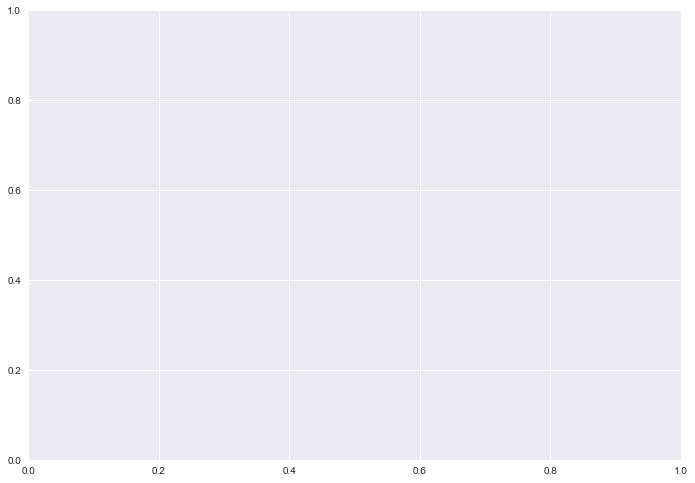

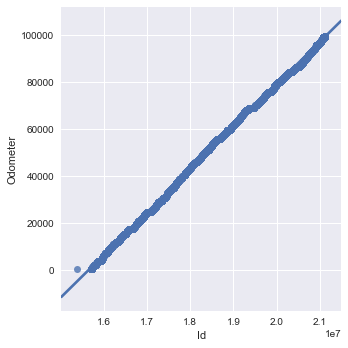

In [55]:
#try with sns
sns.set(style='darkgrid')

f, ax = plt.subplots()

f.set_size_inches(11.7, 8.27)

sns.lmplot(x = 'Id', y = 'Odometer', #col = 'truck',
           data = events_levels_df[events_levels_df.truck == 2063])

plt.show()

#try with sns
sns.set(style='darkgrid')

f, ax = plt.subplots()

f.set_size_inches(11.7, 8.27)

sns.tsplot(time = 'EventTimeStamp', value = 'Odometer',
           #condition = 'truck',
           unit = 'truck',
           data = events_levels_df[0:500],
           ax = ax,
             )
plt.show()

### pick a truck and drill down to it's noise rows to determine whether we should flag or drop them, or imput values

In [56]:
tr1563_events_levels_df = events_levels_df[events_levels_df.truck == 1563]

In [57]:
tr1563_events_levels_df.reset_index(inplace=True)

In [79]:
tr1563_events_levels_df[['EventTimeStamp','Odometer', 'DriverID']].head(10)

,EventTimeStamp,Odometer,DriverID
0,2017-01-02 10:05:26.007,364114.1,COKJ
1,2017-01-02 10:09:15.993,364114.3,COKJ
2,2017-01-02 10:12:55.993,364114.6,COKJ
3,2017-01-02 10:27:56.150,364124.0,COKJ
4,2017-01-02 10:42:56.307,364135.3,COKJ
5,2017-01-02 11:42:57.133,364198.5,COKJ
6,2017-01-02 12:09:17.243,364222.6,COKJ
7,2017-01-02 12:24:17.243,364235.7,COKJ
8,2017-01-02 13:24:17.617,364302.5,COKJ
9,2017-01-02 14:24:17.743,364368.6,COKJ


In [59]:
tr1563_events_levels_df.Odometer.diff().sort_values()
#shows that the noisy readings are about +-97,500 miles off.

6119   -97508.3
1447   -97501.1
1134   -97500.6
848    -97499.9
377    -97498.8
39     -97498.0
67     -97498.0
1337      -63.0
1333      -62.4
5711       -8.0
5709       -8.0
5828       -7.3
768        -6.7
2387       -4.4
2173       -4.4
7121       -3.1
3680       -2.1
4758       -1.7
351        -1.4
5813       -1.2
4236       -1.0
5481       -1.0
4925       -0.9
4162       -0.8
5430       -0.6
6172       -0.6
5438       -0.5
8096       -0.5
7602       -0.5
5812       -0.3
         ...   
8          66.8
1212       66.8
104        66.8
20         66.8
320        66.8
242        66.9
1923       66.9
1634       66.9
334        66.9
331        66.9
912        66.9
1954       66.9
1587       66.9
237        66.9
332        67.0
1589       67.0
1071       67.0
1335       67.0
501        67.0
540        67.0
541        67.0
1073       67.1
37      97498.0
63      97498.1
373     97498.9
846     97500.0
1130    97500.7
1442    97501.4
6117    97508.5
0           NaN
Name: Odometer, Length: 

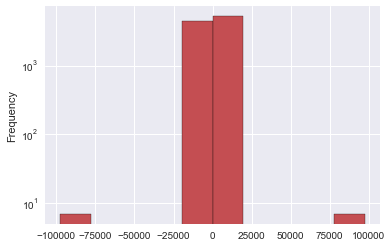

In [87]:
tr1563_events_levels_df.Odometer.diff().plot(kind = 'hist', log = True)
plt.show()

In [60]:
tr1563_events_levels_df['OdomDiff'] = tr1563_events_levels_df.Odometer.diff()

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
tr1563_events_levels_df[abs(tr1563_events_levels_df.OdomDiff) > 100]
#This only gives the rows that are normal, and either preceded by or followed by noise 

,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff
37,31760,12684958,2017-01-03 19:49:36.483,COKJ,29.79517,-95.03312,2017-01-03 19:49:25,0,462342.0,1,0,95.199997,238.00,12684958,1563,250,97498.0
39,31782,12684980,2017-01-03 19:56:36.483,COKJ,29.79517,-95.03312,2017-01-03 19:49:25,0,364844.0,2,0,95.599998,239.00,12684980,1563,250,-97498.0
63,39115,12693233,2017-01-04 09:01:26.357,COKJ,30.06384,-95.90573,2017-01-04 09:01:29,0,462407.5,1,1,83.900002,209.75,12693233,1563,250,97498.1
67,39512,12693630,2017-01-04 09:17:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:17:59,0,364912.7,2,0,83.400002,208.50,12693630,1563,250,-97498.0
373,195798,12864798,2017-01-12 19:15:16.640,COKJ,36.06730,-86.43432,2017-01-12 19:15:18,4,465976.0,1,0,95.900002,239.75,12864798,1563,250,97498.9
377,196200,12865200,2017-01-12 19:59:16.640,COKJ,36.06703,-86.43443,2017-01-12 19:59:18,1,368477.3,1,1,95.699997,239.25,12865200,1563,250,-97498.8
846,447813,13140335,2017-01-27 12:15:41.427,COKJ,34.75100,-81.19888,2017-01-27 12:15:43,1,471229.8,1,0,59.400002,148.50,13140335,1563,250,97500.0
848,448228,13140750,2017-01-27 12:35:21.427,COKJ,34.75060,-81.19897,2017-01-27 12:35:23,0,373729.9,2,0,59.299999,148.25,13140750,1563,250,-97499.9
1130,605588,13313530,2017-02-06 13:16:05.483,NaN,36.06720,-86.43408,2017-02-06 13:16:07,0,474429.4,2,0,98.300003,245.75,13313530,1563,250,97500.7
1134,606594,13314637,2017-02-06 14:09:15.483,NaN,36.06710,-86.43448,2017-02-06 14:09:17,0,376928.8,1,1,98.400002,246.00,13314637,1563,250,-97500.6


In [62]:
tr1563_events_levels_df.loc[30:40]

,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff
30,29808,12682800,2017-01-03 17:23:05.437,COKJ,30.23591,-93.21316,2017-01-03 17:23:05,3,364722.8,1,2,64.000000,160.00,12682800,1563,250,18.0
31,30049,12683041,2017-01-03 17:38:05.517,COKJ,30.22267,-93.31432,2017-01-03 17:38:05,57,364729.0,1,2,64.199997,160.50,12683041,1563,250,6.2
32,30914,12684013,2017-01-03 18:38:05.857,COKJ,29.98453,-94.21143,2017-01-03 18:38:05,61,364789.9,1,2,63.299999,158.25,12684013,1563,250,60.9
33,31488,12684686,2017-01-03 19:27:16.327,COKJ,29.79813,-95.03126,2017-01-03 19:27:16,2,364843.6,1,2,58.599998,146.50,12684686,1563,250,53.7
34,31586,12684784,2017-01-03 19:36:16.483,COKJ,29.79510,-95.03292,2017-01-03 19:36:06,0,364843.9,2,1,60.000000,150.00,12684784,1563,250,0.3
35,31660,12684858,2017-01-03 19:43:36.483,COKJ,29.79539,-95.03304,2017-01-03 19:37:29,0,364844.0,2,1,71.599998,179.00,12684858,1563,250,0.1
36,31670,12684868,2017-01-03 19:45:06.483,COKJ,29.79539,-95.03304,2017-01-03 19:37:29,0,364844.0,2,0,71.599998,179.00,12684868,1563,250,0.0
37,31760,12684958,2017-01-03 19:49:36.483,COKJ,29.79517,-95.03312,2017-01-03 19:49:25,0,462342.0,1,0,95.199997,238.00,12684958,1563,250,97498.0
38,31762,12684960,2017-01-03 19:54:36.483,COKJ,29.79517,-95.03312,2017-01-03 19:49:25,5,462342.0,1,1,95.300003,238.25,12684960,1563,250,0.0
39,31782,12684980,2017-01-03 19:56:36.483,COKJ,29.79517,-95.03312,2017-01-03 19:49:25,0,364844.0,2,0,95.599998,239.00,12684980,1563,250,-97498.0


In [63]:
toydf = tr1563_events_levels_df.loc[60:70]
toydf.reset_index(inplace=True)
toydf

,level_0,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff
0,60,33217,12686643,2017-01-03 22:59:54.027,COKJ,30.06384,-95.90573,2017-01-03 22:59:56,0,364909.4,2,1,82.900002,207.25,12686643,1563,250,0.0
1,61,39025,12693040,2017-01-04 08:56:56.417,COKJ,30.06385,-95.90573,2017-01-04 08:56:59,0,364909.4,2,1,83.199997,208.00,12693040,1563,250,0.0
2,62,39026,12693041,2017-01-04 08:57:06.340,COKJ,30.06385,-95.90573,2017-01-04 08:57:09,0,364909.4,2,0,83.199997,208.00,12693041,1563,250,0.0
3,63,39115,12693233,2017-01-04 09:01:26.357,COKJ,30.06384,-95.90573,2017-01-04 09:01:29,0,462407.5,1,1,83.900002,209.75,12693233,1563,250,97498.1
4,64,39164,12693282,2017-01-04 09:03:26.387,COKJ,30.06493,-95.90656,2017-01-04 09:03:29,9,462407.6,1,0,82.900002,207.25,12693282,1563,250,0.1
5,65,39391,12693509,2017-01-04 09:12:36.590,COKJ,30.05334,-95.87198,2017-01-04 09:12:39,0,462410.7,2,1,80.000000,200.00,12693509,1563,250,3.1
6,66,39461,12693579,2017-01-04 09:15:56.607,COKJ,30.05334,-95.87198,2017-01-04 09:15:59,0,462410.7,1,1,83.400002,208.50,12693579,1563,250,0.0
7,67,39512,12693630,2017-01-04 09:17:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:17:59,0,364912.7,2,0,83.400002,208.50,12693630,1563,250,-97498.0
8,68,39525,12693643,2017-01-04 09:18:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:18:59,0,364912.7,2,1,83.400002,208.50,12693643,1563,250,0.0
9,69,39992,12694110,2017-01-04 09:40:36.730,COKJ,30.05327,-95.87069,2017-01-04 09:40:39,7,364912.8,1,1,83.300003,208.25,12694110,1563,250,0.1


In [88]:
toydf['flag_for_drop'] = np.nan #initialize an empty column
toydf

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,level_0,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff,flag_for_drop
0,60,33217,12686643,2017-01-03 22:59:54.027,COKJ,30.06384,-95.90573,2017-01-03 22:59:56,0,364909.4,2,1,82.900002,207.25,12686643,1563,250,0.0,NaN
1,61,39025,12693040,2017-01-04 08:56:56.417,COKJ,30.06385,-95.90573,2017-01-04 08:56:59,0,364909.4,2,1,83.199997,208.00,12693040,1563,250,0.0,NaN
2,62,39026,12693041,2017-01-04 08:57:06.340,COKJ,30.06385,-95.90573,2017-01-04 08:57:09,0,364909.4,2,0,83.199997,208.00,12693041,1563,250,0.0,NaN
3,63,39115,12693233,2017-01-04 09:01:26.357,COKJ,30.06384,-95.90573,2017-01-04 09:01:29,0,462407.5,1,1,83.900002,209.75,12693233,1563,250,97498.1,NaN
4,64,39164,12693282,2017-01-04 09:03:26.387,COKJ,30.06493,-95.90656,2017-01-04 09:03:29,9,462407.6,1,0,82.900002,207.25,12693282,1563,250,0.1,NaN
5,65,39391,12693509,2017-01-04 09:12:36.590,COKJ,30.05334,-95.87198,2017-01-04 09:12:39,0,462410.7,2,1,80.000000,200.00,12693509,1563,250,3.1,NaN
6,66,39461,12693579,2017-01-04 09:15:56.607,COKJ,30.05334,-95.87198,2017-01-04 09:15:59,0,462410.7,1,1,83.400002,208.50,12693579,1563,250,0.0,NaN
7,67,39512,12693630,2017-01-04 09:17:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:17:59,0,364912.7,2,0,83.400002,208.50,12693630,1563,250,-97498.0,NaN
8,68,39525,12693643,2017-01-04 09:18:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:18:59,0,364912.7,2,1,83.400002,208.50,12693643,1563,250,0.0,NaN
9,69,39992,12694110,2017-01-04 09:40:36.730,COKJ,30.05327,-95.87069,2017-01-04 09:40:39,7,364912.8,1,1,83.300003,208.25,12694110,1563,250,0.1,NaN


In [89]:
####################

flag = -1 #this will be flipped like a switch -1 means do not drop, 1 means drop

#loop through each row of the df
for i in range(len(toydf.Odometer)-1):
    
    #will start by flaggin with -1 (do not drop) until an anomaly flips it.
    toydf.flag_for_drop[i] = flag 
    
    # for each truck, if odometer change is anomalous (i.e. spikes up or down) flip the flag switch
    if (toydf.truck[i + 1] == toydf.truck[i]) & (abs(toydf.Odometer[i + 1] - toydf.Odometer[i]) > 200): 
        flag = -1*flag
        #the flag will remain on the delete (i.e. 1) setting until the loop detects the spike that corrects the odometer
        
    # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. -1)   
    #if tr1563_events_levels_df.truck[i + 1] != tr1563_events_levels_df.truck[i]:
     #   flag = -1

####################

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
toydf

,level_0,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff,flag_for_drop
0,60,33217,12686643,2017-01-03 22:59:54.027,COKJ,30.06384,-95.90573,2017-01-03 22:59:56,0,364909.4,2,1,82.900002,207.25,12686643,1563,250,0.0,-1.0
1,61,39025,12693040,2017-01-04 08:56:56.417,COKJ,30.06385,-95.90573,2017-01-04 08:56:59,0,364909.4,2,1,83.199997,208.00,12693040,1563,250,0.0,-1.0
2,62,39026,12693041,2017-01-04 08:57:06.340,COKJ,30.06385,-95.90573,2017-01-04 08:57:09,0,364909.4,2,0,83.199997,208.00,12693041,1563,250,0.0,-1.0
3,63,39115,12693233,2017-01-04 09:01:26.357,COKJ,30.06384,-95.90573,2017-01-04 09:01:29,0,462407.5,1,1,83.900002,209.75,12693233,1563,250,97498.1,1.0
4,64,39164,12693282,2017-01-04 09:03:26.387,COKJ,30.06493,-95.90656,2017-01-04 09:03:29,9,462407.6,1,0,82.900002,207.25,12693282,1563,250,0.1,1.0
5,65,39391,12693509,2017-01-04 09:12:36.590,COKJ,30.05334,-95.87198,2017-01-04 09:12:39,0,462410.7,2,1,80.000000,200.00,12693509,1563,250,3.1,1.0
6,66,39461,12693579,2017-01-04 09:15:56.607,COKJ,30.05334,-95.87198,2017-01-04 09:15:59,0,462410.7,1,1,83.400002,208.50,12693579,1563,250,0.0,1.0
7,67,39512,12693630,2017-01-04 09:17:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:17:59,0,364912.7,2,0,83.400002,208.50,12693630,1563,250,-97498.0,-1.0
8,68,39525,12693643,2017-01-04 09:18:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:18:59,0,364912.7,2,1,83.400002,208.50,12693643,1563,250,0.0,-1.0
9,69,39992,12694110,2017-01-04 09:40:36.730,COKJ,30.05327,-95.87069,2017-01-04 09:40:39,7,364912.8,1,1,83.300003,208.25,12694110,1563,250,0.1,-1.0


In [68]:
def flag_anomal_odom_rows(df):
    
    df['flag_for_drop'] = np.nan
    
    flag = -1 #this will be flipped like a switch -1 means do not drop, 1 means drop

    #loop through each row of the df
    for i in range(len(df.Odometer)-1):
        
        #will start by flaggin with -1 (do not drop) until an anomaly flips it.
        df.flag_for_drop[i] = flag 
        
        # for each truck, if odometer change is anomalous (i.e. spikes up or down) flip the flag switch
        if (df.truck[i + 1] == df.truck[i]) & (abs(df.Odometer[i + 1] - df.Odometer[i]) > 200): 
            flag = -1*flag
            #the flag will remain on the delete (i.e. 1) setting until the loop detects the spike that corrects the odometer
            
        # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. -1)   
        #if df.truck[i + 1] != df.truck[i]:
         #   flag = -1
    return df

In [146]:
flag_anomal_odom_rows(toydf)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

,level_0,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff,flag_for_drop
0,60,33217,12686643,2017-01-03 22:59:54.027,COKJ,30.06384,-95.90573,2017-01-03 22:59:56,0,364909.4,2,1,82.900002,207.25,12686643,1563,250,0.0,-1.0
1,61,39025,12693040,2017-01-04 08:56:56.417,COKJ,30.06385,-95.90573,2017-01-04 08:56:59,0,364909.4,2,1,83.199997,208.00,12693040,1563,250,0.0,-1.0
2,62,39026,12693041,2017-01-04 08:57:06.340,COKJ,30.06385,-95.90573,2017-01-04 08:57:09,0,364909.4,2,0,83.199997,208.00,12693041,1563,250,0.0,-1.0
3,63,39115,12693233,2017-01-04 09:01:26.357,COKJ,30.06384,-95.90573,2017-01-04 09:01:29,0,462407.5,1,1,83.900002,209.75,12693233,1563,250,97498.1,1.0
4,64,39164,12693282,2017-01-04 09:03:26.387,COKJ,30.06493,-95.90656,2017-01-04 09:03:29,9,462407.6,1,0,82.900002,207.25,12693282,1563,250,0.1,1.0
5,65,39391,12693509,2017-01-04 09:12:36.590,COKJ,30.05334,-95.87198,2017-01-04 09:12:39,0,462410.7,2,1,80.000000,200.00,12693509,1563,250,3.1,1.0
6,66,39461,12693579,2017-01-04 09:15:56.607,COKJ,30.05334,-95.87198,2017-01-04 09:15:59,0,462410.7,1,1,83.400002,208.50,12693579,1563,250,0.0,1.0
7,67,39512,12693630,2017-01-04 09:17:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:17:59,0,364912.7,2,0,83.400002,208.50,12693630,1563,250,-97498.0,-1.0
8,68,39525,12693643,2017-01-04 09:18:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:18:59,0,364912.7,2,1,83.400002,208.50,12693643,1563,250,0.0,-1.0
9,69,39992,12694110,2017-01-04 09:40:36.730,COKJ,30.05327,-95.87069,2017-01-04 09:40:39,7,364912.8,1,1,83.300003,208.25,12694110,1563,250,0.1,-1.0


In [73]:
tr1564_events_levels_df = events_levels_df[events_levels_df.truck == 1564]
tr1564_events_levels_df.reset_index(inplace=True)

In [74]:
tr1564_events_levels_df

,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,4,12649103,2017-01-01 00:10:13.187,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.75,12649103,1564,250
1,44,12649143,2017-01-01 00:12:23.187,ULAL,39.90267,-84.19318,2017-01-01 00:12:21,9,498691.1,1,1,50.599998,126.50,12649143,1564,250
2,45,12649144,2017-01-01 00:14:13.187,ULAL,39.90259,-84.19231,2017-01-01 00:14:11,0,498691.2,2,1,50.400002,126.00,12649144,1564,250
3,46,12649145,2017-01-01 00:14:34.267,ULAL,39.90262,-84.19234,2017-01-01 00:14:32,0,498691.2,2,0,50.400002,126.00,12649145,1564,250
4,47,12649146,2017-01-01 00:32:13.267,ULAL,39.90261,-84.19228,2017-01-01 00:32:11,0,498691.2,2,1,48.799999,122.00,12649146,1564,250
5,48,12649147,2017-01-01 00:36:23.297,ULAL,39.90302,-84.19245,2017-01-01 00:36:21,9,498691.2,1,0,48.000000,120.00,12649147,1564,250
6,49,12649148,2017-01-01 00:51:23.390,ULAL,39.75214,-84.18651,2017-01-01 00:51:21,57,498703.8,1,2,48.000000,120.00,12649148,1564,250
7,113,12649244,2017-01-01 01:51:23.623,ULAL,39.42987,-83.17320,2017-01-01 01:51:22,65,498766.5,1,2,48.000000,120.00,12649244,1564,250
8,149,12649305,2017-01-01 02:22:33.763,ULAL,39.16550,-82.73743,2017-01-01 02:22:33,0,498798.4,1,2,46.099998,115.25,12649305,1564,250
9,150,12649306,2017-01-01 02:24:13.763,ULAL,39.16544,-82.73734,2017-01-01 02:24:13,0,498798.4,2,1,45.400002,113.50,12649306,1564,250


In [75]:
flag_anomal_odom_rows(tr1564_events_levels_df[0:100])

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,flag_for_drop
0,4,12649103,2017-01-01 00:10:13.187,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.75,12649103,1564,250,-1.0
1,44,12649143,2017-01-01 00:12:23.187,ULAL,39.90267,-84.19318,2017-01-01 00:12:21,9,498691.1,1,1,50.599998,126.50,12649143,1564,250,-1.0
2,45,12649144,2017-01-01 00:14:13.187,ULAL,39.90259,-84.19231,2017-01-01 00:14:11,0,498691.2,2,1,50.400002,126.00,12649144,1564,250,-1.0
3,46,12649145,2017-01-01 00:14:34.267,ULAL,39.90262,-84.19234,2017-01-01 00:14:32,0,498691.2,2,0,50.400002,126.00,12649145,1564,250,-1.0
4,47,12649146,2017-01-01 00:32:13.267,ULAL,39.90261,-84.19228,2017-01-01 00:32:11,0,498691.2,2,1,48.799999,122.00,12649146,1564,250,-1.0
5,48,12649147,2017-01-01 00:36:23.297,ULAL,39.90302,-84.19245,2017-01-01 00:36:21,9,498691.2,1,0,48.000000,120.00,12649147,1564,250,-1.0
6,49,12649148,2017-01-01 00:51:23.390,ULAL,39.75214,-84.18651,2017-01-01 00:51:21,57,498703.8,1,2,48.000000,120.00,12649148,1564,250,-1.0
7,113,12649244,2017-01-01 01:51:23.623,ULAL,39.42987,-83.17320,2017-01-01 01:51:22,65,498766.5,1,2,48.000000,120.00,12649244,1564,250,-1.0
8,149,12649305,2017-01-01 02:22:33.763,ULAL,39.16550,-82.73743,2017-01-01 02:22:33,0,498798.4,1,2,46.099998,115.25,12649305,1564,250,-1.0
9,150,12649306,2017-01-01 02:24:13.763,ULAL,39.16544,-82.73734,2017-01-01 02:24:13,0,498798.4,2,1,45.400002,113.50,12649306,1564,250,-1.0


In [76]:
tr1564_events_levels_df

,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,4,12649103,2017-01-01 00:10:13.187,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.75,12649103,1564,250
1,44,12649143,2017-01-01 00:12:23.187,ULAL,39.90267,-84.19318,2017-01-01 00:12:21,9,498691.1,1,1,50.599998,126.50,12649143,1564,250
2,45,12649144,2017-01-01 00:14:13.187,ULAL,39.90259,-84.19231,2017-01-01 00:14:11,0,498691.2,2,1,50.400002,126.00,12649144,1564,250
3,46,12649145,2017-01-01 00:14:34.267,ULAL,39.90262,-84.19234,2017-01-01 00:14:32,0,498691.2,2,0,50.400002,126.00,12649145,1564,250
4,47,12649146,2017-01-01 00:32:13.267,ULAL,39.90261,-84.19228,2017-01-01 00:32:11,0,498691.2,2,1,48.799999,122.00,12649146,1564,250
5,48,12649147,2017-01-01 00:36:23.297,ULAL,39.90302,-84.19245,2017-01-01 00:36:21,9,498691.2,1,0,48.000000,120.00,12649147,1564,250
6,49,12649148,2017-01-01 00:51:23.390,ULAL,39.75214,-84.18651,2017-01-01 00:51:21,57,498703.8,1,2,48.000000,120.00,12649148,1564,250
7,113,12649244,2017-01-01 01:51:23.623,ULAL,39.42987,-83.17320,2017-01-01 01:51:22,65,498766.5,1,2,48.000000,120.00,12649244,1564,250
8,149,12649305,2017-01-01 02:22:33.763,ULAL,39.16550,-82.73743,2017-01-01 02:22:33,0,498798.4,1,2,46.099998,115.25,12649305,1564,250
9,150,12649306,2017-01-01 02:24:13.763,ULAL,39.16544,-82.73734,2017-01-01 02:24:13,0,498798.4,2,1,45.400002,113.50,12649306,1564,250


In [152]:
# lets try to optimize the performance of the flagging function

def flag_anomal_odom_rows_2(df):#!!!! requires a dataframe with a reset index!!!!
    '''takes a dataframe with an Odometer column and returns a boolean index of 
    identifying which rows are noisy Odometer readings and should be dropped'''
    
    #initialize a series, without attaching it to the df in the hopes of expediency
    OdomDiff = df.Odometer.diff()
    
    #initialize list which will serve as a boolean index
    flags = []
    
    flag = 1 #this will be flipped like a switch 1 means do not drop, 0 means drop

    #loop through each difference measurement
    for i in range(len(OdomDiff) - 1):
    # the loop will flag all but the last row because otherwise I'd have to find a way to loop around the "corner" of the index
    #            
    #   #will start by flaggin with 1 (do not drop) until an anomaly flips it.
        flags.append(bool(flag))
    #    
    #   # for each truck, if odometer change is anomalous (i.e. spikes up or down) flip the flag switch
        if (df.truck[i + 1] == df.truck[i]) & (abs(OdomDiff[i + 1]) > 200): 
            flag = (flag + 1)%2
    #       #the flag will remain on the delete (i.e. 0) setting until the loop detects the spike that corrects the odometer
    #       
    #   # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. 1)   
        if df.truck[i + 1] != df.truck[i]:
            flag = 1
    #        
    #now that the loop is done, we append the last flag (which is in the state the loop left it. So, if a loop ends before the anomaly is corrected, the flag will still be set at 0/False)
    flags.append(bool(flag))
    
    return flags

In [153]:
flag_anomal_odom_rows_2(toydf)

[True, True, True, False, False, False, False, True, True, True, True]

In [154]:
toydf

,level_0,index,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap,OdomDiff,flag_for_drop
0,60,33217,12686643,2017-01-03 22:59:54.027,COKJ,30.06384,-95.90573,2017-01-03 22:59:56,0,364909.4,2,1,82.900002,207.25,12686643,1563,250,0.0,-1.0
1,61,39025,12693040,2017-01-04 08:56:56.417,COKJ,30.06385,-95.90573,2017-01-04 08:56:59,0,364909.4,2,1,83.199997,208.00,12693040,1563,250,0.0,-1.0
2,62,39026,12693041,2017-01-04 08:57:06.340,COKJ,30.06385,-95.90573,2017-01-04 08:57:09,0,364909.4,2,0,83.199997,208.00,12693041,1563,250,0.0,-1.0
3,63,39115,12693233,2017-01-04 09:01:26.357,COKJ,30.06384,-95.90573,2017-01-04 09:01:29,0,462407.5,1,1,83.900002,209.75,12693233,1563,250,97498.1,1.0
4,64,39164,12693282,2017-01-04 09:03:26.387,COKJ,30.06493,-95.90656,2017-01-04 09:03:29,9,462407.6,1,0,82.900002,207.25,12693282,1563,250,0.1,1.0
5,65,39391,12693509,2017-01-04 09:12:36.590,COKJ,30.05334,-95.87198,2017-01-04 09:12:39,0,462410.7,2,1,80.000000,200.00,12693509,1563,250,3.1,1.0
6,66,39461,12693579,2017-01-04 09:15:56.607,COKJ,30.05334,-95.87198,2017-01-04 09:15:59,0,462410.7,1,1,83.400002,208.50,12693579,1563,250,0.0,1.0
7,67,39512,12693630,2017-01-04 09:17:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:17:59,0,364912.7,2,0,83.400002,208.50,12693630,1563,250,-97498.0,-1.0
8,68,39525,12693643,2017-01-04 09:18:56.607,COKJ,30.05326,-95.87195,2017-01-04 09:18:59,0,364912.7,2,1,83.400002,208.50,12693643,1563,250,0.0,-1.0
9,69,39992,12694110,2017-01-04 09:40:36.730,COKJ,30.05327,-95.87069,2017-01-04 09:40:39,7,364912.8,1,1,83.300003,208.25,12694110,1563,250,0.1,-1.0


In [165]:
#Ok, let's test it on a truck's slice
ti = datetime.now()
print(ti)
flags = flag_anomal_odom_rows_2(tr1563_events_levels_df)
tf = datetime.now()
print(tf)
print('function took about: ', tf-ti)
flags

2018-05-03 18:57:57.550485
2018-05-03 18:57:58.157687
function took about:  0:00:00.607202


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,


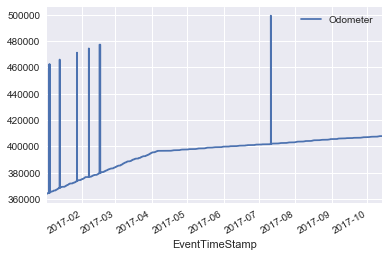

In [167]:
tr1563_events_levels_df.plot(x = 'EventTimeStamp', y = 'Odometer')
plt.show()

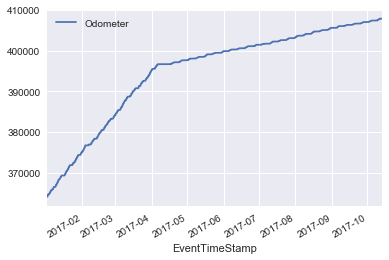

In [168]:
tr1563_events_levels_df[flags].plot(x = 'EventTimeStamp', y = 'Odometer')
plt.show()

In [162]:
#Ok, let's test it on a truck's slice
ti = datetime.now()
print(ti)
flags = flag_anomal_odom_rows_2(tr1564_events_levels_df)
tf = datetime.now()
print(tf)
print('function took about: ', tf-ti)
flags

2018-05-03 18:55:27.414089
2018-05-03 18:55:27.890493
function took about:  0:00:00.476404


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

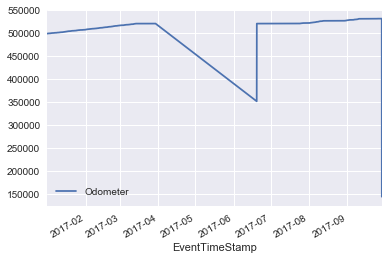

In [163]:
tr1564_events_levels_df.plot(x = 'EventTimeStamp', y = 'Odometer')
plt.show()

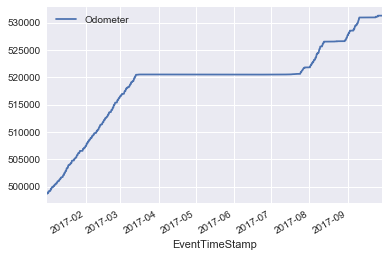

In [164]:
tr1564_events_levels_df[flags].plot(x = 'EventTimeStamp', y = 'Odometer')
plt.show()

#### get the events ids to drop and give them to team

In [169]:
##Ok, let's test it on the whole df
ti = datetime.now()
print(ti)
flags = flag_anomal_odom_rows_2(events_levels_df)
tf = datetime.now()
print(tf)
print('function took about: ', tf-ti)
flags

2018-05-03 19:26:06.906936
2018-05-03 19:39:04.064088
function took about:  0:12:57.157152


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [183]:
inv_flags = [False == b for b in flags]

In [185]:
False == False

True

In [187]:
inv_flags

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [188]:
sum(inv_flags)

411

In [191]:
list(events_levels_df.Id[inv_flags])

[12657126,
 12657127,
 12746275,
 12946311,
 13039741,
 13092342,
 13092343,
 13092344,
 13092345,
 13092346,
 13092347,
 13092555,
 13156996,
 13156997,
 13174091,
 13313530,
 13381098,
 13381099,
 13381100,
 13381101,
 13381102,
 13381103,
 13555164,
 13555165,
 13566460,
 13636409,
 13729945,
 13729946,
 13780017,
 13810682,
 13838489,
 13912193,
 13912251,
 13914679,
 13914680,
 13935785,
 14083809,
 14089445,
 14160586,
 14237432,
 14237433,
 14237448,
 14237449,
 14238192,
 14242725,
 14261769,
 14261770,
 14261771,
 14328059,
 14328060,
 14328061,
 14328062,
 14351176,
 14351177,
 14359863,
 14359864,
 14417642,
 14417643,
 14417644,
 14417645,
 14447049,
 14544626,
 14544627,
 14557081,
 14557505,
 14564960,
 14564961,
 14585667,
 14668575,
 14730292,
 14730293,
 14730294,
 14730295,
 14781469,
 14781470,
 14871213,
 14871214,
 14871215,
 14871237,
 14898651,
 14898652,
 14898653,
 14898654,
 14898655,
 14898656,
 14898657,
 14898658,
 14898659,
 14898660,
 14898661,
 14898662,

In [175]:
type(flags)

list

In [171]:
len(flags) == events_levels_df.shape[0]

True

In [174]:
sum(flags)

7907995

In [173]:
len(flags) - sum(flags)

411

In [172]:
events_levels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908406 entries, 0 to 7908405
Data columns (total 15 columns):
Id                   uint64
EventTimeStamp       datetime64[ns]
DriverID             category
Latitude             float64
Longitude            float64
LocationTimeStamp    datetime64[ns]
Speed                uint16
Odometer             float64
IgnitionStatus       category
EFReportReason       category
TankLevelPercent     float32
TankLevelGallons     float32
ExactFuelEventId     uint64
truck                uint32
tankcap              uint16
dtypes: category(3), datetime64[ns](2), float32(2), float64(3), uint16(2), uint32(1), uint64(2)
memory usage: 633.6 MB


In [ ]:
#this is un untested augmentation of flag_anomal_odom_rows_2
def drop_anomal_rows_by_col(df, noisy_col = 'Odometer'
                            sort_col_1 = 'truck', 
                            sort_col_2 = 'EventTimeStamp'):#!!!! requires a dataframe with a reset index!!!!
    '''Takes a dataframe with a noisy column, sorts df by two columns,
    makes a boolean index of it's noisy rows and drops them. Returns the df'''
    
    #sort the df by truck and EventTimeStamp
    df.sort_values([sort_col_1, sort_col_2], inplace = True)
    
    
    #initialize a series, without attaching it to the df in the hopes of expediency
    OdomDiff = df.Odometer.diff()
    
    #initialize list which will serve as a boolean index
    flags = []
    
    flag = 1 #this will be flipped like a switch 1 means do not drop, 0 means drop

    #loop through each difference measurement
    for i in range(len(OdomDiff) - 1):
    # the loop will flag all but the last row because otherwise I'd have to find a way to loop around the "corner" of the index
    #            
    #   #will start by flaggin with 1 (do not drop) until an anomaly flips it.
        flags.append(bool(flag))
    #    
    #   # for each truck, if odometer change is anomalous (i.e. spikes up or down) flip the flag switch
        if (df.truck[i + 1] == df.truck[i]) & (abs(OdomDiff[i + 1]) > 200): 
            flag = (flag + 1)%2
    #       #the flag will remain on the delete (i.e. 0) setting until the loop detects the spike that corrects the odometer
    #       
    #   # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. 1)   
        if df.truck[i + 1] != df.truck[i]:
            flag = 1
    #        
    #now that the loop is done, we append the last flag (which is in the state the loop left it. So, if a loop ends before the anomaly is corrected, the flag will still be set at 0/False)
    flags.append(bool(flag))
    
    #now drop the noisy rows in the df
    df = df[flags]
    
    return df

In [192]:
events_levels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908406 entries, 0 to 7908405
Data columns (total 15 columns):
Id                   uint64
EventTimeStamp       datetime64[ns]
DriverID             category
Latitude             float64
Longitude            float64
LocationTimeStamp    datetime64[ns]
Speed                uint16
Odometer             float64
IgnitionStatus       category
EFReportReason       category
TankLevelPercent     float32
TankLevelGallons     float32
ExactFuelEventId     uint64
truck                uint32
tankcap              uint16
dtypes: category(3), datetime64[ns](2), float32(2), float64(3), uint16(2), uint32(1), uint64(2)
memory usage: 633.6 MB


In [1]:
events_levels_df.info()

NameError: name 'events_levels_df' is not defined